<a href="https://colab.research.google.com/github/chrisrichardson/intrusion-thermal/blob/main/Thermal_Intrusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded


In [ ]:
def keff(T):
    '''
    Calculate effective value of diffusivity as
    a function of temperature taking into account Latent Heat of Fusion
    kappa = k / rho [ Cp + L/deltaT ]
    Typical values:
    Density rho = 3000 kg/m3
    Thermal conductivity k = 3 W/m/K
    Heat capacity Cp = 1000 J/kg/K
    Latent heat of fusion L = 500000 J/kg
    Melting interval deltaT = 200 K
    '''

    keff = 1.0/(1.0 + 2.06 * (T>980))
    return keff

In [ ]:
def matA(T, gam):
    ''' Discretisation of the diffusion equation:
    dT/dt = k(T) d2T/dx2
    using a backward-Euler method in 1D, resulting in a
    tridiagonal matrix system A.T(n+1) = T(n).
    Use a tridiagonal solver (e.g. scipy solve_banded).
    Boundary conditions are set to zero flux at x=0 (i.e. symmetric)
    and to fixed T on the other edge of the domain.
    '''
    nr = len(T)
    k=keff(T)
    A=np.zeros((3, nr))
    for i in range(1, nr-1):
        A[0, i+1] = -gam*k[i]
        A[1, i] = 1. + 2.*gam*k[i]
        A[2, i-1] = -gam*k[i]

    # B.C. at x=0, no flux.
    A[0,1] = -4.0 * gam*k[0]
    A[1,0] = 1. + 4.0 * gam*k[0]

    #B.C. at x=nr*dx
    A[1, nr-1] = 1.0
    A[2, nr-2] = 0.0

    return A


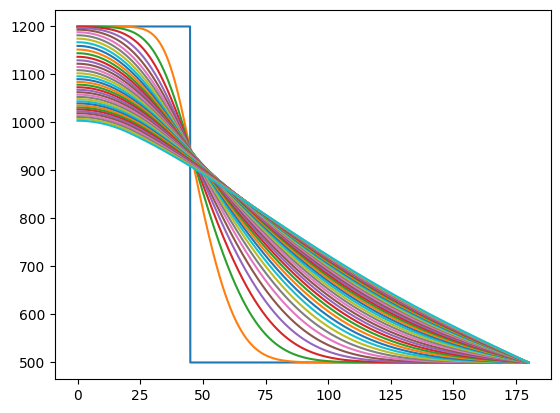

In [ ]:
n = 450
T = np.empty(4 * n)
T[0:n] = 1200.0
T[n:] = 500.0

dx = 0.1
xx = np.arange(0, len(T) * dx, dx)
dt = 2.0
gam = dt/dx/dx

cool_time = np.zeros_like(T)

t = 0.0
i = 0
while(T[0] > 1000):
  if (i % 50 == 0):
    plt.plot(xx, T)
  A = matA(T, gam)
  T = solve_banded((1, 1), A, T)
  cool_time[np.where(T>1000)] = t
  t += dt
  i += 1

plt.show()

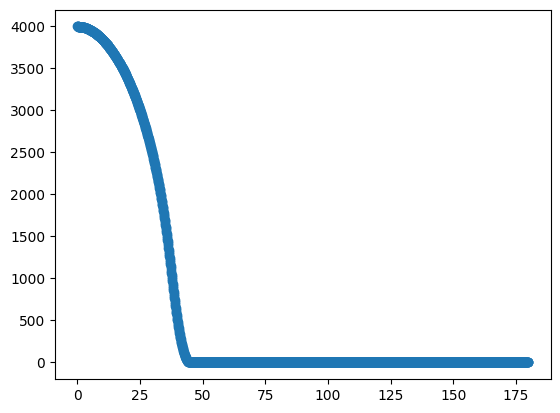

In [ ]:
plt.scatter(xx, cool_time)